<a href="https://colab.research.google.com/github/SvenRelijveld1995/Magnus-hackathon/blob/main/Eerste_Magnus_Hackaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eerste Magnus Hackaton


Welkom bij de eerste Magnus hackaton. Misschien heb je je tijdens Leefbaarweekend gebogen over het bordspel in het rekenkundemuseum. Hier volgt:
1. Doel
2. Tips
3. Code definities
4. Reeds geimplementeerd
5. Taakomschrijving
6. Toetsing

Woorden in `monospace` zul je terugvinden in de code.
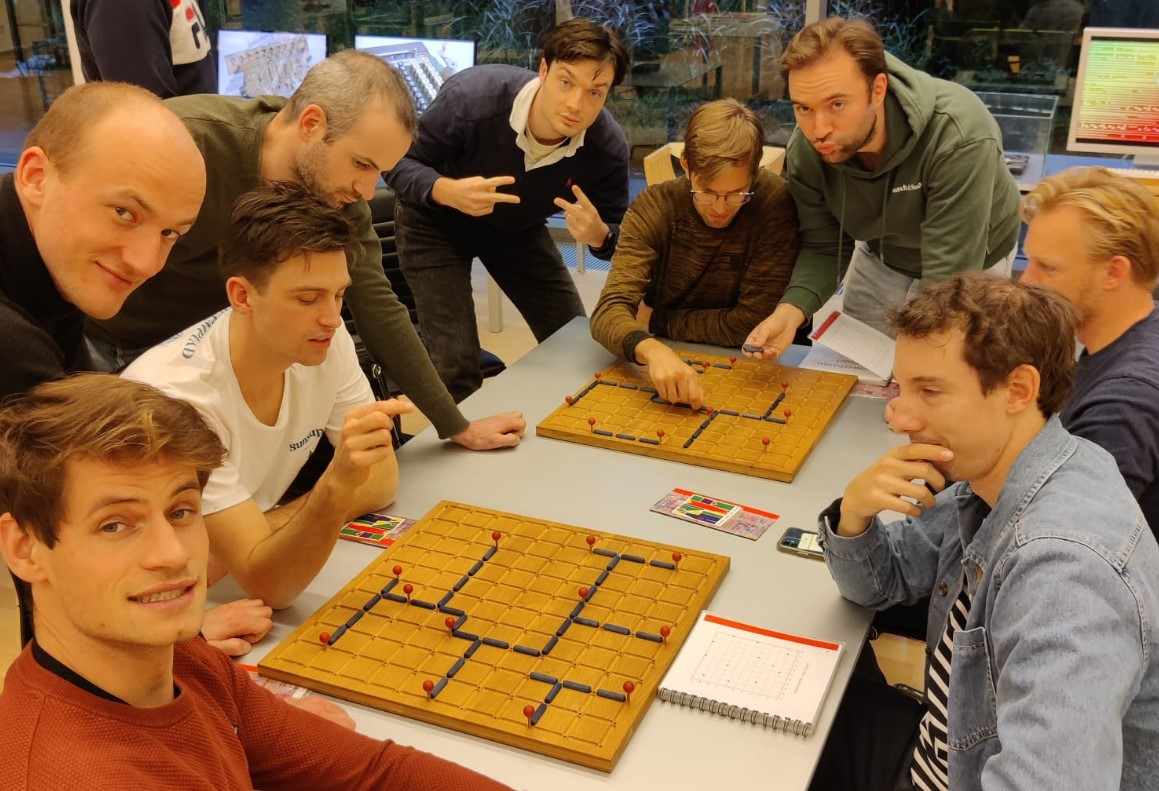
# Doel
Gegeven is een `board` van 10 bij 10 vierkante tegels. Op de hoeken van deze tegels kunnen `pins` staan. Het bord bevat 5 t/m 12 van deze pins. Het hoofddoel van het spel is om deze pins met elkaar te verbinden. Je verbindt deze tegel met `path elements`. Deze path elements kan je plaatsen op de rand tussen twee tegels, ze hebben dus altijd een lengte van één. Wanneer alle pins verbonden zijn is doel twee om hierbij zo min mogelijk path elements te gebruiken.

# Tips
*   Dit probleem (het vinden van de kortste route om alle punten te bereiken) heet een Traveling Salesman Problem. Er zijn echter twee verschillen: Je hoeft niet terug te komen bij waar je begonnen bent, en het terug"lopen" over een `path` wordt niet dubbel geteld.
*   Deze manier van afstand bereken over een grid heet "Manhattan Distance" of de L1-afstand.

# Code definities
*   `board`: `points` op het bord bestaan uit een x en y-component. Omdat de matrix uit 10 tegels bestaat in beide richtingen zijn is het minimum van de x en y-componenten 0, en het maximum 11. Points mogen geen decimalen bevatten.
*   `pin`: een pin heeft alleen een point bijvoorbeeld `(3, 4)`.
*   `pins` is een `list` bestaande uit `pin` elementen.
*   `path_element`: bestaat uit een start point en een eind point, de volgorde maakt niet uit. De Manhattan afstand tussen het start en eind point moet altijd 1 zijn. Bijvoorbeeld `((3, 4), (4, 4))`.
*   `paths` is een `list` bestaande uit `path_elements`.

# Reeds geïmplementeerd
Veel functies zijn al geimplementeerd zodat jij je kan focussen op het pad-algoritme, in volgorde van belang:
*   `display_board`, hier kan je paths en pins in gooien en hij visualiseert het voor je.
*   `validate_paths`, gooi je hier een pad in, dan checkt hij hem op alle bovengenoemde regels, dat helpt je met debuggen. Deze functie returnt niets, maar raiset enkel een error wanneer er iets mis is.
*   `get_clusters`, bewandelt al je paden en geeft een label aan aaneengesloten delen. Als er maar één label in je pins voorkomt weet je dat je alle pins bereikt hebt.

# Taakomschrijving
In volgorde van urgentie:
1. Schrijf je oplossing `find_paths`.
2. Om te kijken voor welke scenario's je oplossing werk bewerk je `set_pins`.
3. Verbeter je performance estimation door het gebruik van `score_solution` uit te breiden.  

# Toetsing
Uiteindelijk zal je oplossing getoetst worden een test set van 29 scenario's uit het boekje waar Thomas foto's van heeft gemaakt. De resultaten hiervan zullen in eerste plaats worden gerankschikt op aantal geslaagde verbindingen. Bij een gelijk aantal geslaagde verbindingen wordt de som over alle gebruikte paden genomen.
Zorg dat de totale rekentijd voor alle 29 scenario's niet ver boven de 1 minuut zit. NB: je `find_paths` functie heeft een argument `target` dat je kan gebruiken om je zoeken vroegtijdig te stoppen wanneer je je doel bereikt hebt.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from typing import List, Tuple, Dict


# Object types
Point = Tuple[int, int]
Points = List[Point]
PathElement = Tuple[Point, Point]
Paths = List[PathElement]

# Colors
path_blue = '#5f65ba'
tile_dark = '#cd913b'
tile_light = '#d7a053'
pin_red = '#ca2801'

from typing import List, Tuple

# Object types
Point = Tuple[int, int]
Points = List[Point]
PathElement = Tuple[Point, Point]
Paths = List[PathElement]


def flatten(nested_list: List[List]) -> list:
    """
    Unnests a nested list.

    Parameters:
    - nested_list (List[List]): The nested list to be flattened.

    Returns:
    - list: Flattened list.

    Example:
    > flatten([[1], [2]])  # Returns [1, 2]
    """
    return [sub_list for sup_list in nested_list for sub_list in sup_list]


def sort_paths(paths: Paths) -> Paths:
    """
    Sorts points within paths to avoid duplicate paths like A -> B and B -> A.

    Parameters:
    - paths (Paths): List of paths, where each path is a tuple of two points (PathElement).

    Returns:
    - Paths: Sorted paths.

    Example:
    > sort_paths([((0, 1), (1, 0)), ((2, 3), (1, 2))])  # Returns [((0, 1), (1, 0)), ((1, 2), (2, 3))]
    """
    return [tuple(map(tuple, sorted(path, key=lambda x: (x[0], x[1])))) for path in paths]


def rm_duplicate_pins(pins: Points) -> Points:
  """
  Removes duplicate pins from the list of pins.

  Parameters:
  - pins (Points): List of pins, where each pin is a point (Point).

  Returns:
  - Points: List of unique pins.

  Note:
  Prints a message if duplicates were found.

  Example:
  > rm_duplicate_pins([(0, 1), (2, 3), (0, 1)])  # Prints 'Pins contained 1 duplicate which was purged.'
  """
  n_non_unique = len(pins) - len(set(pins))
  if n_non_unique:
    was, s = ("was", "") if n_non_unique == 1 else ("were", "s")
    print(f'Pins contained {n_non_unique} duplicate{s} which {was} purged.')
  return list(set(pins))


def rm_duplicate_paths(paths: Paths) -> Paths:
  """
  Removes duplicate paths from the list of paths.

  Parameters:
  - paths (Paths): List of paths, where each path is a tuple of two points (PathElement).

  Returns:
  - Paths: List of unique paths.

  Note:
  Prints a message if duplicates were found.

  Example:
  > rm_duplicate_paths([((0, 1), (1, 0)), ((2, 3), (1, 2)), ((1, 0), (0, 1))])
  # Prints 'Paths contained 1 duplicate which was purged.' and returns [((0, 1), (1, 0)), ((1, 2), (2, 3))]
  """
  sorted_paths = sort_paths(paths)
  unique_paths = list(set(sorted_paths))
  n_non_unique = len(paths) - len(unique_paths)
  if n_non_unique:
    was, s = ("was", "") if n_non_unique == 1 else ("were", "s")
    print(f'Paths contained {n_non_unique} duplicate{s} which {was} purged.')
  return unique_paths


def manhattan_distance(point1: Point, point2: Point) -> int:
  """
  Computes Manhattan distance between two points.

  Parameters:
  - point1 (Point): First point (x, y).
  - point2 (Point): Second point (x, y).

  Returns:
  - int: Manhattan distance between the two points.

  Example:
  > manhattan_distance((0, 0), (1, 2))  # Returns 3
  """
  x1, y1 = point1
  x2, y2 = point2
  return int(abs(x2 - x1) + abs(y2 - y1))


def scalar_to_color(scalar_list: list) -> list:
  """
  Converts scalars to colors for plotting purposes. (Not in use)

  Parameters:
  - scalar_list (list): List of scalar values.

  Returns:
  - list: List of colors corresponding to scalar values.

  Example:
  > scalar_to_color([0, 1, 2])  # Returns a list of colors mapped from the scalar values.
  """
  # Note: The function is not in use and may require modification based on specific use cases.
  # This example assumes matplotlib is available for color mapping.
  # The function may need further customization based on actual use.
  pass


def validate_paths(paths: Paths, size=10) -> None:
  """
  Raises an error if the list of paths contains anything improperly formatted.

  Parameters:
  - paths (Paths): List of paths, where each path is a tuple of two points
    (PathElement).
  - size (int): Size of the board (number of tiles in each row/column).
    Default is 10.

  Raises:
  - TypeError: If paths is not of type list or if a path element is not a
    tuple.
  - ValueError: If a path element does not consist of a start and end point,
    if a point is not an x-y pair, if a value is not an integer, if a value is
    not an integer, if a value is less than 0 or greater than the specified
    size, or if a path element is not of length 1.

  Examples:
  > validate_paths([((0, 0), (0, 2))])  # Raises ValueError
  """
  if not isinstance(paths, list):
    raise TypeError(f'Paths should be of type list, but is of type {type(paths).__name__} {paths}.')
  for i, path in enumerate(paths):
    if not isinstance(path, tuple):
      raise TypeError(f'Path element {i} should be a tuple, but is a {type(path).__name__} {path}.')
    if not len(path) == 2:
      s = "" if len(path) == 1 else "s"
      raise ValueError(f'Path element {i} should consist of a start and end point. Instead it consists of {len(path)} point{s} {path}.')
    for point in path:
      if not isinstance(point, tuple):
        raise TypeError(f'Path element {i} contained a point that was not a tuple, a {type(point).__name__} {path}.')
      if not len(point) == 2:
        s = "" if len(point) == 1 else "s"
        raise ValueError(f'Path element {i} contained a point that was not an x-y pair, but {len(point)} value{s} instead {path}.')
      for value in point:
        if not isinstance(value, int) and not isinstance(value, float):
          type_name = type(value).__name__
          raise TypeError(f'Path element {i} contained a value that was of type {type_name} and only ints and floats are accepted {path}.')
        if value % 1:
          raise ValueError(f'Path element {i} contained a value that was not an integer {path}.')
        if value < 0:
          raise ValueError(f'Path element {i} was not on the board ( < 0) {path}.')
        elif value > size:
          raise ValueError(f'Path element {i} was not on the board ( > {size}) {path}.')
    path_length = manhattan_distance(*path)
    if path_length != 1:
      raise ValueError(f'Path element {i} should be of length 1, but is of length {path_length} ({path}).')


def get_clusters(paths: Paths, pins: Points = []) -> Tuple[Dict, Dict]:
  """
  Clusters pins and paths to common labels. For each, it returns a dictionary
  with points as keys and the cluster label as the value. Pins are optional.

  Parameters:
  - paths (Paths): List of paths, where each path is a tuple of points (PathElement).
  - pins (Points): List of pins, where each pin is a point (Point). Default is an empty list.

  Returns:
  A tuple containing two dictionaries:
  - path_clusters (Dict[Point, int]): A dictionary mapping points in paths to their cluster labels.
  - pin_clusters (Dict[Point, int]): A dictionary mapping pins to their cluster labels.

  Notes:
  This method is used to check success (all pins in the same cluster) but can
  also be used for visualization purposes.
  """
  # Validate input data
  if not isinstance(paths[0][0], tuple):
    raise ValueError(f'Invalid path data: {paths}, did you accidentally provide pin data inst')

  # Populate connections based on paths between pins
  point_owners = {}
  for i, points in enumerate(paths):
    for point in points:
      if point not in point_owners:
        point_owners[point] = [i]
      else:
        point_owners[point].append(i)

  label = 0
  path_clusters = {}
  while True:
    # Check if there are unvisited starting points
    starts = [path[0] for path in paths if path[0] not in path_clusters]
    if not any(starts):
      break
    # Perform a depth-first search (DFS) starting from the first pin
    to_visit = [starts[0]]
    while any(to_visit):
      point = to_visit.pop()
      path_clusters[point] = label
      for point_owner in point_owners[point]:
        for point in paths[point_owner]:
          if point not in path_clusters:
            to_visit.append(point)
    label += 1
  pin_clusters = {}
  for pin in pins:
    if pin not in path_clusters:
      pin_clusters[pin] = label
      label += 1
    else:
      pin_clusters[pin] = path_clusters[pin]
  return path_clusters, pin_clusters


def display_board(
    paths: Paths = [],
    pins: Points = [],
    size=10,
    suptitle=None,
    path_colors=path_blue,
    pin_colors=pin_red,
    target: int=None,
) -> None:
  """
  Display a board with paths and pins.
  All parameters are optional.

  Parameters:
  - paths (Paths): List of paths, where each path is a list of points (PathElement).
  - pins (Points): List of pins, where each pin is a point (Point).
  - size (int): Size of the board (number of tiles in each row/column).
  - suptitle (str): Subtitle for the plot.
  - path_colors: Colors for paths, can be a string or a list of colors.
  - pin_colors: Colors for pins, can be a string or a list of colors.
  - target (int): Target number for successful connections.

  Returns:
  None
  """
  fig, ax = plt.subplots(figsize=(5, 4))
  # Drawing tiles
  be = 1  # Board edge width
  ax.add_patch(patches.Rectangle((-be/2, -be/2), size + be, size + be, fc=tile_dark))
  for i in range(size):
    for j in range(size):
      rect = patches.Rectangle((i, j), 1, 1, lw=2, edgecolor=tile_light, fc=tile_dark)
      ax.add_patch(rect)

  # Drawing paths
  if any(paths):
    # Validate if the input data is correctly formatted
    validate_paths(paths, size=size)

    # Purge duplicate paths
    paths = rm_duplicate_paths(paths)

    # Convert single colors to list, or s
    if isinstance(path_colors, str):
      path_colors = [path_colors] * len(paths)
    elif not isinstance(path_colors[0], str):
      path_colors = scalar_to_color(path_colors)

    # Drawing paths
    for color, path in zip(path_colors, paths):
      (x1, y1), (x2, y2) = path
      if x1 == x2:  # Vertical path
        ax.plot([x1, x2], [min(y1, y2) + .15, max(y1, y2) - .15], c=color, lw=3)
      elif y1 == y2:  # Horizontal path
        ax.plot([min(x1, x2) + .15, max(x1, x2) - .15], [y1, y2], c=color, lw=3)
      else:
        print(f"Invalid path: {path}")

  # Drawing pin holes
  g = size + 1  # grid size
  ax.plot(flatten([range(g)] * g), flatten([[i] * g for i in range(g)]), '.k', ms=.5)

  # Drawing pins
  if any(pins):
    if isinstance(pin_colors, str):
      pin_colors = [pin_colors] * len(pins)
    elif not isinstance(pin_colors[0], str):
      pin_colors = scalar_to_color(pin_colors)

    pin_coords = np.array(pins).T
    ax.scatter(pin_coords[0], pin_coords[1], color=pin_colors, s=100, zorder=5)

  # Check if connections are successful
  msg = 'un'
  if any(paths) and any(pins):
    _, pin_clusters = get_clusters(paths, pins)
    n_clusters = len(set(pin_clusters.values()))
    if n_clusters == 1:
      msg = ''

  # Set x-axis labels as letters
  ax.set_xticks(np.arange(size) + .5)
  ax.set_xticklabels([chr(65 + i) for i in range(size)], fontsize=12)

  # Set y-axis labels as numerals
  ax.set_yticks(np.arange(size) + .5)
  ax.set_yticklabels(np.arange(1, size + 1), fontsize=12)

  # Turn off grids, set limits and make square
  ax.grid(False)
  ax.spines[:].set_visible(False)
  ax.set_aspect('equal')
  ax.set_xlim(-be/2, size + be/2)
  ax.set_ylim(-be/2, size + be/2)
  ax.tick_params(axis='both', which='both', length=0)

  # Set the figure title
  tgt = '' if target is None else f'/{target}'
  ttl = f'{msg}succesful with {len(paths)}{tgt} path elements'.capitalize()
  ttl = ttl if suptitle is None else f'{suptitle}\n{ttl}'
  ax.set_title(ttl)

  # Display image
  plt.show()


def score_solution() -> Tuple[bool, int, Paths]:
  # Generate a training scenario
  pins, target = set_pins()

  # Execute your solution
  paths = find_paths(pins, target)

  # Score the solution
  path_clusters, pin_clusters = get_clusters(paths, pins)

  # Check if all pins are in the same clusters
  is_success = len(set(pin_clusters.values())) == 1

  # Return if the solution was successfull, and if so, how many paths were used.
  return is_success, len(paths), paths


# Jouw oplossing

All pins were connected using 14 path elements.



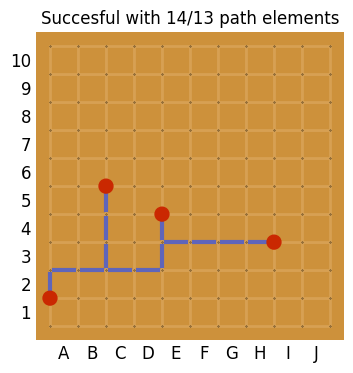

In [ ]:
def set_pins() -> Tuple[Points, int]:
  """
  This function returns the pins that your solution will try to connect.
  Edit this function to see if your solution works in different scenarios.
  Test cases will contain 8-14 pins.
  """
  pins = [(0, 1), (4, 4), (8, 3), (2, 5)]
  target = 13
  return pins, target


def find_paths(pins: Points, target: int=None) -> Paths:
  """
  This function contains your solution. It returns the paths to be tested.
  """
  paths = [
    ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 2), (2, 2)), ((2, 2), (3, 2)),
    ((3, 2), (4, 2)), ((4, 2), (4, 3)), ((4, 3), (4, 4)), ((2, 2), (2, 3)),
    ((2, 3), (2, 4)), ((2, 4), (2, 5)), ((4, 3), (5, 3)), ((5, 3), (6, 3)),
    ((6, 3), (7, 3)), ((7, 3), (8, 3)),
  ]
  return paths


# Calculate the score
is_success, n_paths, paths = score_solution()

# Print the score to the console
if is_success:
  print(f'All pins were connected using {n_paths} path elements.\n')
else:
  print('The paths did not connect all pins.\n')

# Optional: visualize
pins, target = set_pins()
display_board(paths, pins, target=13)

# Testopzet
Hier onder staat een voorbeeld van de test opzet.
Kom hier niet aan. Als de code hieronder de output van de functie `set_pins` en `find_paths` niet meer kan interpreteren, dan kunnen we je methode aan het einde ook niet testen. Wil je tijdens de ontwikkeling

In [ ]:
import pandas as pd
from tqdm import tqdm

# Define test data
tests={"schwierigkeit-leicht_pins-4_kanten-13":[(0, 1), (4, 4), (8, 3), (2, 5)], }

# Sort difficulties in order
difficulties  = ['sehrleicht', 'leicht', 'mittel', 'schwer', 'sehrschwer', 'extremschwer']

# Define a data frame where we will store our results to
score = pd.DataFrame(columns=['schw_int', 'schwierigkeit', 'pins', 'kanten', 'is_successful', 'paths_used', 'score'])
score.index.name = 'Test #'

results = {}
for i, (test_name, test_pins) in enumerate(tqdm(tests.items())):
  # Read the test description from the file name
  difficulty, pins, target = [k.split('-')[1] for k in test_name.split('_')][:3]
  target = int(target)

  # Make the pin reader return the test
  def set_pins() -> Tuple[Points, int]: return test_pins, target

  # Perform the test
  is_successful, paths_used, paths = score_solution()

  # Store the path found for later visualization
  results[test_name] = target, paths

  # Store test result in data frame
  score.loc[i] = [difficulties.index(difficulty), difficulty, pins, target, is_successful, paths_used, int(target) - paths_used]

# Sort the data frame by difficulty and drop the sorting column
score = score.sort_values(by=['schw_int'], ascending=True)
score = score.drop(columns=['schw_int'])

# Display the score
print('\n\n', score, f'\n\nTotal score: {score.is_successful.sum()}/{len(tests)} successes, with nett {score.score.sum()} paths.')

100%|██████████| 1/1 [00:00<00:00, 464.74it/s]



        schwierigkeit pins kanten  is_successful  paths_used  score
Test #                                                            
0             leicht    4     13           True          14     -1 

Total score: 1/1 successes, with nett -1 paths.


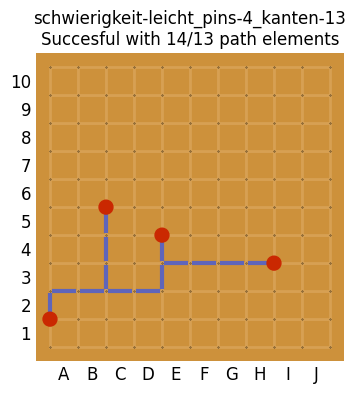

In [ ]:
# Choose which test to show from your results
test_no = 0

# Load results information
test_name = list(tests)[test_no]
pins = tests[test_name]
target, paths = results[test_name]
display_board(paths, pins, suptitle=test_name, target=target)